## Entrenamiento

#### Importación de las librerías

In [1]:
import pyarrow.feather as feather
import importlib
import numpy as np
import matplotlib.pyplot as plt
import utils.train_utils as train_utils
import torch
from torch import nn

importlib.reload(train_utils)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from utils.train_utils import run_model
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset



#### Cargado de datos

In [6]:
X_train = feather.read_feather("./results/X_train.ftr")
X_test = feather.read_feather("./results/X_test.ftr")
y_train = feather.read_feather("./results/y_train.ftr").to_numpy().ravel()
y_test = feather.read_feather("./results/y_test.ftr").to_numpy().ravel()

### Adaboost

ROC_AUC = 0.9285620168587724

              precision    recall  f1-score   support

           0    0.94090   0.93193   0.93639     14573
           1    0.91405   0.92520   0.91959     11403

    accuracy                        0.92897     25976
   macro avg    0.92748   0.92856   0.92799     25976
weighted avg    0.92912   0.92897   0.92902     25976



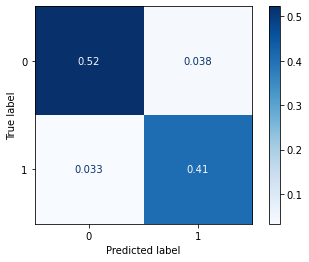

In [70]:
params_ad = {
    "n_estimators": 100,
    "random_state": 0,
}

model_ad = AdaBoostClassifier(**params_ad)
model_ad, roc_auc_ad = run_model(model_ad, X_train, y_train, X_test, y_test)

### SVM

In [71]:
params_svm = {}

model_svm = SVC(**params_svm)
model_svm, roc_auc_svm = run_model(model_svm, X_train, y_train, X_test, y_test)

### Decision tree

ROC_AUC = 0.9450319122351295

              precision    recall  f1-score   support

           0    0.95139   0.95224   0.95182     14573
           1    0.93889   0.93782   0.93836     11403

    accuracy                        0.94591     25976
   macro avg    0.94514   0.94503   0.94509     25976
weighted avg    0.94591   0.94591   0.94591     25976



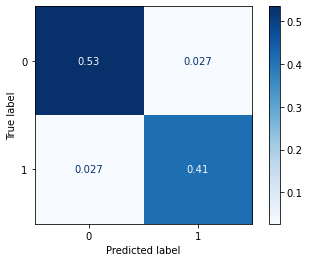

In [ ]:
params_dt = {}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, roc_auc_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

### Random forest

ROC_AUC = 0.9615529341528721

              precision    recall  f1-score   support

           0    0.95890   0.97660   0.96767     14573
           1    0.96937   0.94651   0.95780     11403

    accuracy                        0.96339     25976
   macro avg    0.96414   0.96155   0.96274     25976
weighted avg    0.96350   0.96339   0.96334     25976



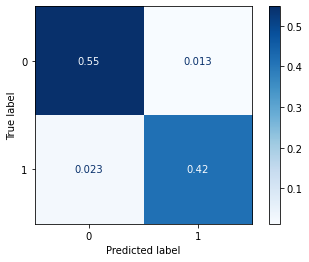

In [ ]:
params_rf = {
    'max_depth': 25,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 1200,
    'random_state': 42
}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

### Logistic regression

ROC_AUC = 0.859699316601944
              precision    recall  f1-score   support

           0    0.89560   0.84533   0.86974     14573
           1    0.81556   0.87407   0.84380     11403

    accuracy                        0.85795     25976
   macro avg    0.85558   0.85970   0.85677     25976
weighted avg    0.86047   0.85795   0.85835     25976



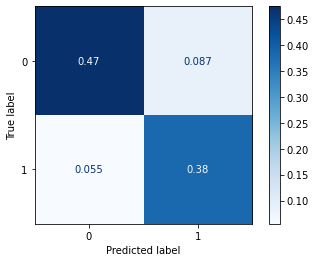

In [ ]:
params_lr = {
    'random_state': 42
}

model_lr = LogisticRegression(**params_lr)
model_lr, roc_auc_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

### Neural network

In [71]:
# Se crea el modelo a entrenar
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer_1 = nn.Linear(19, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

model = Net()

In [72]:
# Se define el dataset
class CustomDataset(Dataset):
  def __init__(self, X, Y):
    super().__init__()
    self.X = torch.tensor(X.values).float()
    self.Y = torch.tensor(Y).float()

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    x = self.X[idx]
    y = self.Y[idx]
    return x, y

In [73]:
# Se crean los dataloaders
params = {
    'batch_size': 64,
    'shuffle': True,
}

train_set = CustomDataset(X_train, y_train)
test_set = CustomDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, **params)
test_loader = torch.utils.data.DataLoader(test_set, **params)

cpu


KeyboardInterrupt: 

In [74]:
def fit(model, criterion, optimizer, dataloaders, epochs=50):
  # Se entrena el modelo
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(device)
  if torch.cuda.is_available():
    model.cuda()
  losses_train = []
  losses_val = []
  running_loss = 0.0
  for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      correct = 0
      correct_val = 0
      model = model.train()
      for i, data in enumerate(dataloaders["train"]):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels.unsqueeze(1))
          loss.backward()
          preds = torch.round(torch.sigmoid(outputs))
          optimizer.step()
          running_loss += loss.item()
          correct += (preds == labels.unsqueeze(1)).float().sum()
      model = model.eval() 
      with torch.no_grad():
        valid_loss = 0.0
        for i, data in enumerate(dataloaders["val"]):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            valid_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            correct_val += (preds == labels.unsqueeze(1)).float().sum()


      print('[%d] training loss: %.5f, validation loss: %.5f' %(epoch + 1, running_loss / len(train_loader), valid_loss / len(dataloaders["val"])), end="")
      print(", train accuracy {}, val accuracy {}".format(100 * correct / len(train_set), 100 * correct_val / len(test_set)))
      losses_train.append(running_loss / len(train_loader))
      losses_val.append(valid_loss / len(dataloaders["val"]))
  return losses_train, losses_val

In [76]:
# Se entrena el modelo
dataloaders = {"train": train_loader, "val": test_loader,}
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01,)

losses_train, losses_val = fit(model, criterion, optimizer, dataloaders)